# The Empire State Building Strikes Back

In [19]:
import numpy
import pandas
from matplotlib import pyplot
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import modsim

# Dropping pennies

In [20]:
init = modsim.State(y=318, v=0)
init

y    318
v      0
Name: state, dtype: int64

In [21]:
system = modsim.System(
    init=init, # initial conditions
    g=9.8,     # acceleration due to gravity
    t_end=10,  # duration of the simulation
)

In [22]:
# run_solve_ivp can solve systems of first order DEs, but here we have 2nd order
# The slope function uses the fact that the second order DE can be turned into first order,
# making use of: a = dv/dt, v = dy/dt.

def slope_func(t, state, system):
    y, v = state

    dydt = v
    # a = -g indicates that acceleration due to gravity is in the direction of decreasing y
    dvdt = -system.g  
    
    return dydt, dvdt

In [23]:
dydt, dvdt = slope_func(0, system.init, system)
dydt, dvdt

(0, -9.8)

In [24]:
results, details = modsim.run_solve_ivp(system, slope_func)
details.message

'The solver successfully reached the end of the integration interval.'

In [25]:
results.head()

,y,v
0.0,318.000,0.00
0.1,317.951,-0.98
0.2,317.804,-1.96
0.3,317.559,-2.94
0.4,317.216,-3.92


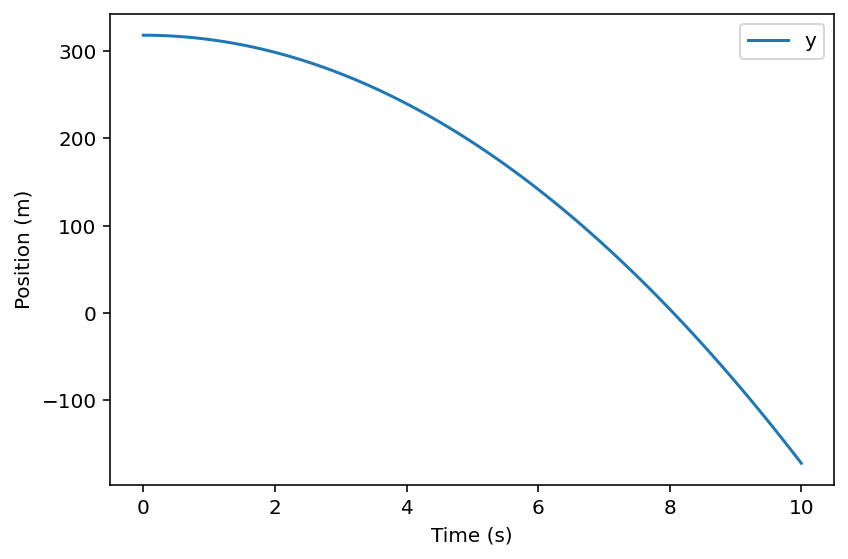

In [26]:
results.y.plot()
modsim.decorate(xlabel='Time (s)', ylabel='Position (m)')

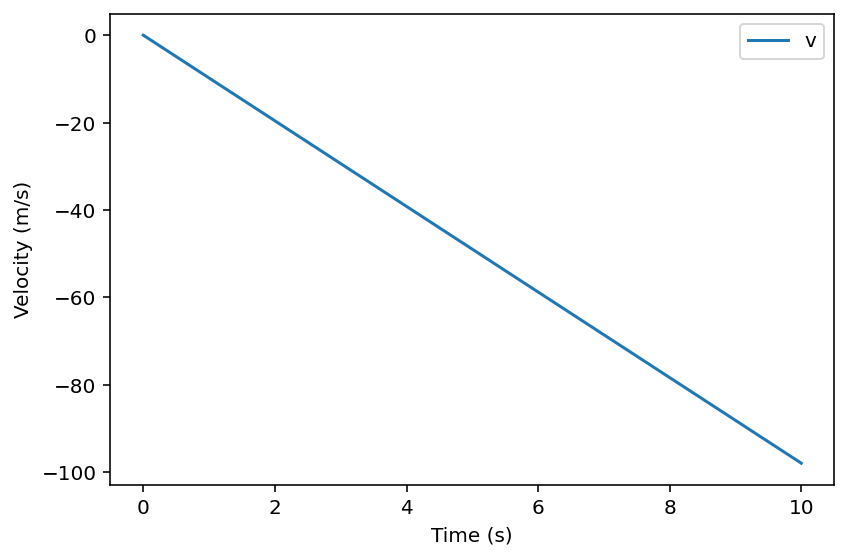

In [27]:
results.v.plot()
modsim.decorate(xlabel='Time (s)', ylabel='Velocity (m/s)')

The negative values of the position indicates that we run the simulation for too long.

In [28]:
t_crossings = modsim.crossings(results.y, 0)
t_crossings # and returns a sequence of times when the series passes through the value

array([8.05592696])

### Events

In [29]:
def event_func(t, state, system):
    y, v = state
    return y

In [30]:
results, details = modsim.run_solve_ivp(system, slope_func, events=event_func)
details.message

'A termination event occurred.'

In [31]:
t_end = results.index[-1]
t_end

8.055926959926682

In [32]:
y, v = results.iloc[-1]
y, v

(-1.1368683772161603e-13, -78.94808420728151)

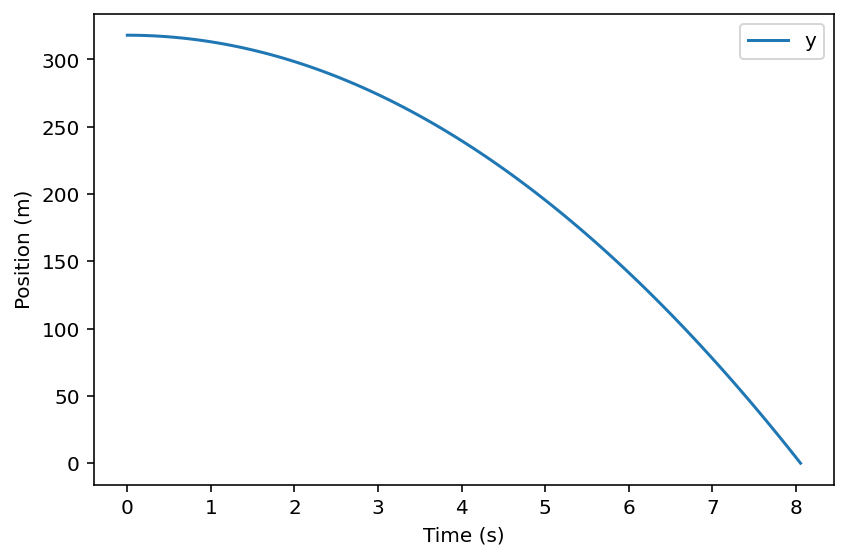

In [33]:
results.y.plot()
modsim.decorate(xlabel='Time (s)', ylabel='Position (m)')

### Exercise 1
Here’s a question from the web site Ask an Astronomer (see http://curious.astro.cornell.edu/about-us/39-our-solar-system/the-earth/other-catastrophes/57-how-long-would-it-take-the-earth-to-fall-into-the-sun-intermediate):

> “If the Earth suddenly stopped orbiting the Sun, I know eventually it would be pulled in by the Sun’s gravity and hit it. How long would it take the Earth to hit the Sun? I imagine it would go slowly at first and then pick up speed.”

Use `run_solve_ivp` to answer this question.

Here are some suggestions about how to proceed:

Look up the Law of Universal Gravitation and any constants you need. I suggest you work entirely in SI units: meters, kilograms, and Newtons.

When the distance between the Earth and the Sun gets small, this system behaves badly, so you should use an event function to stop when the surface of Earth reaches the surface of the Sun.

Express your answer in days, and plot the results as millions of kilometers versus days.

If you read the reply by Dave Rothstein, you will see other ways to solve the problem, and a good discussion of the modeling decisions behind them.

You might also be interested to know that it’s not that easy to get to the Sun; see https://www.theatlantic.com/science/archive/2018/08/parker-solar-probe-launch-nasa/567197/.

In [38]:
r_0 = 150e9   # 150 million km in m
v_0 = 0
init = modsim.State(r=r_0, v=v_0)

In [39]:
radius_earth = 6.37e6  # meters
radius_sun = 696e6     # meters
r_final = radius_sun + radius_earth
r_final

702370000.0

In [40]:
t_end = 1e7  # seconds

system = modsim.System(
    init=init,
    G=6.674e-11,   # N m^2 / kg^2
    m1=1.989e30,   # kg
    m2=5.972e24,   # kg
    r_final=radius_sun + radius_earth,
    t_end=t_end,
)

In [41]:
def universal_gravitation(state, system):
    """Computes gravitational force.
    
    state: State object with distance r
    system: System object with m1, m2, and G
    """
    r, v = state
    G, m1, m2 = system.G, system.m1, system.m2
    
    force = G * m1 * m2 / r**2
    return force

In [42]:
universal_gravitation(init, system)

3.5233701151999997e+22

In [43]:
def slope_func(t, state, system):
    y, v = state
    m2 = system.m2    

    force = universal_gravitation(state, system)
    dydt = v
    dvdt = -force / m2
    
    return dydt, dvdt

In [44]:
slope_func(0, system.init, system)


(0.0, -0.005899815999999999)

In [46]:
def event_func(t, state, system):
    r, v = state
    return r - system.r_final

In [47]:
event_func(0, init, system)


149297630000.0

In [59]:
results, details = modsim.run_solve_ivp(system, slope_func, events=event_func)
details.message

'A termination event occurred.'

In [60]:
t_event = results.index[-1]
t_event / 60 / 60 / 24

64.81282615067751

In [61]:
results.index /= 60 * 60 * 24 # seconds to days

In [62]:
results.r /= 1e9

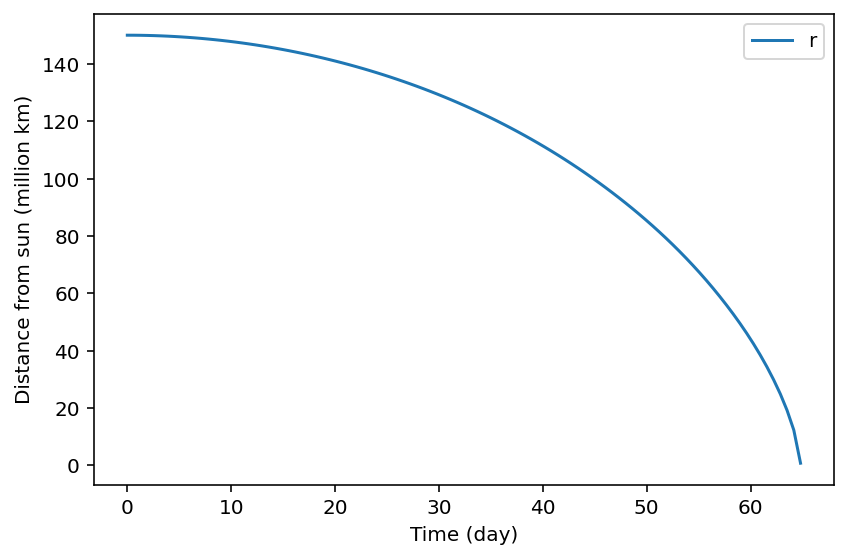

In [63]:
results.r.plot(label='r')

modsim.decorate(xlabel='Time (day)', ylabel='Distance from sun (million km)')